In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310 
from aver5_funcs import get_data
import pickle 
from scipy import stats
import requests
from tqdm import tqdm
from time import sleep, perf_counter
from threading import Thread

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [3]:
len(subset_symbols)

346

In [4]:
import time 

In [5]:
int(time.time())*1000

1690039951000

In [40]:
def get_time_before(minutes=10):
    return (int(time.time())-minutes*60)*1000

In [41]:
start_time = 1690021502000 #2023-07-22 18:30:00
offset=8*3600*1000

In [54]:
5*1000/60/24

3.472222222222222

# todo:
- do predictions for top 10 tickers at 5m resolution
- then use hourly/30m-ly 24hr change to find datasets to validate this analysis/prediction

In [80]:
#def task2(id):
id=1
start_time = 1690021502000-1050*3600*1000 #2023-07-22 18:30:00
offset=8*3600*1000
sleep(id*0.1)# 0.05 works
dfmpl0 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=start_time-3600_000*24,offset=offset)
sleep(0.05) # only for 5m interval
dfmpl1 =get_data(subset_symbols[id]+"USDT","5m",limit=1000,start_time=dfmpl0.iloc[-1].name.value//1000_000-offset+5*60_000,offset=offset)
dff=pd.concat([dfmpl0,dfmpl1])
data_fetched2[id]=(dff.iloc[0:2000-24*60//5].copy(),dff.iloc[24*60//5:].copy())
if id%10==0:
    print(f'{id}',end=",")

In [64]:
dfmpl0.iloc[-1].name.value//1000_000

1686483900000

In [ ]:
1690021502000

In [59]:
data_fetched2 = [[None,None] for v in subset_symbols]
#task2(1)

In [57]:
data_fetched2[1][1]

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-09 00:30:00,0.5214,0.5218,0.5212,0.5214,733759.0
2023-06-09 00:35:00,0.5213,0.5218,0.5208,0.5211,909440.0
2023-06-09 00:40:00,0.5211,0.5212,0.5206,0.5206,502361.0
2023-06-09 00:45:00,0.5206,0.5215,0.5196,0.5201,1389202.0
2023-06-09 00:50:00,0.5202,0.5217,0.5200,0.5216,523774.0
...,...,...,...,...,...
2023-06-12 11:25:00,0.5140,0.5142,0.5128,0.5140,1186788.0
2023-06-12 11:30:00,0.5140,0.5143,0.5129,0.5133,1140436.0
2023-06-12 11:35:00,0.5133,0.5148,0.5132,0.5146,1144925.0


In [58]:
data_fetched2[1][0]

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-08 00:30:00,0.5104,0.5131,0.5085,0.5128,2997569.0
2023-06-08 00:35:00,0.5129,0.5132,0.5085,0.5095,4093919.0
2023-06-08 00:40:00,0.5095,0.5110,0.5085,0.5108,2134484.0
2023-06-08 00:45:00,0.5109,0.5125,0.5100,0.5121,1978447.0
2023-06-08 00:50:00,0.5122,0.5122,0.5105,0.5107,2122194.0
...,...,...,...,...,...
2023-06-11 11:25:00,0.5074,0.5074,0.5066,0.5068,337525.0
2023-06-11 11:30:00,0.5069,0.5074,0.5068,0.5068,289150.0
2023-06-11 11:35:00,0.5068,0.5076,0.5067,0.5073,380720.0


In [ ]:
data_fetched2 = [[None,None] for v in subset_symbols]
start_time = perf_counter() 
threads = []
for n in range(len(subset_symbols)):
    t = Thread(target=task2, args=(n,))
    threads.append(t)
    t.start() 
for t in threads:
    t.join()
end_time = perf_counter()
print(f'\ntook {end_time- start_time: 0.2f} s to complete.')

In [7]:
with open("9_0_5_data_fetched2.pkl","rb") as f:
    data_fetched2 = pickle.load(f)

#  trying to predict the order of top 10 tickers, assuming the current fluctuations are small.

- for all tickers, find the 5m candles in the past 24hrs and then calculate the % change wrt current time. 
- get the order of tickers for the next 5,10,15mins.

- see if this order correspond to the actual results

In [8]:
len(subset_symbols)

346

In [10]:
tickerpair="STMXUSDT"
interval="5m"

df_5m_befor = get_data(tickerpair,interval,limit=5,start_time=start_time-3600_000*24,offset=offset)
df_5m_after = get_data(tickerpair,interval,limit=5,start_time=start_time,offset=offset)

print("\ndf_5m_befor\n")
print(df_5m_befor)
print("\ndf_5m_after\n")
print(df_5m_after)

print("\ncurrent ticker time",df_5m_after.iloc[-1].name,"\n")

for i in range(len(df_5m_befor)):
    print(f"{(df_5m_after.iloc[-1].Close - df_5m_befor.iloc[i].Close)/df_5m_befor.iloc[i].Close:.4%}",df_5m_befor.iloc[i].name)


df_5m_befor

                         Open      High       Low     Close      Volume
Date                                                                   
2023-07-21 18:30:00  0.005666  0.005685  0.005627  0.005684  15025452.0
2023-07-21 18:35:00  0.005684  0.005747  0.005625  0.005625  42479615.0
2023-07-21 18:40:00  0.005631  0.005687  0.005596  0.005665  23461613.0
2023-07-21 18:45:00  0.005666  0.005669  0.005625  0.005634   9816794.0
2023-07-21 18:50:00  0.005634  0.005655  0.005498  0.005510  31952159.0

df_5m_after

                         Open      High       Low     Close      Volume
Date                                                                   
2023-07-22 18:30:00  0.006467  0.006467  0.006416  0.006416  15921820.0
2023-07-22 18:35:00  0.006419  0.006426  0.006380  0.006395  12579571.0
2023-07-22 18:40:00  0.006393  0.006404  0.006375  0.006403   5347190.0
2023-07-22 18:45:00  0.006405  0.006458  0.006389  0.006431   9608983.0
2023-07-22 18:50:00  0.006431  0.006

In [20]:
%%time
lengs=[]
for i in range(len(data_fetched2)):
    dfmpl_befor, dfmpl_after = data_fetched2[i]
    lengs.append(len(dfmpl_befor))
    lengs.append(len(dfmpl_after))
assert all(np.asarray(lengs)==len(dfmpl_befor)) # all df have the same length

CPU times: total: 0 ns
Wall time: 2 ms


In [34]:
%%time
hr24change = [(dfmpl_after.Close.values-dfmpl_befor.Close.values)/dfmpl_befor.Close.values for dfmpl_befor, dfmpl_after in data_fetched2]
hr24change = np.asarray(hr24change)
dfmpl_befor, dfmpl_after = data_fetched2[2]
argsort = np.argsort(-hr24change,axis=0)

CPU times: total: 0 ns
Wall time: 22 ms


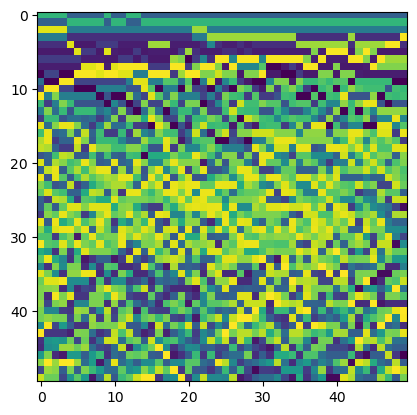

In [39]:
plt.imshow(argsort[:50],aspect=1,interpolation="none")

# end of file

In [26]:
assert False

data_fetched2 = [[None,None] for v in subset_symbols]
def task2(id): 
    start_time = 1690021502000 #2023-07-22 18:30:00
    offset=8*3600*1000
    sleep(id*0.1)# 0.05 works
    dfmpl0 =get_data(subset_symbols[id]+"USDT","5m",limit=50,start_time=start_time-3600_000*24,offset=offset)
    sleep(0.05)
    dfmpl1 =get_data(subset_symbols[id]+"USDT","5m",limit=50,start_time=start_time,offset=offset)
    data_fetched2[id]=(dfmpl0.copy() ,dfmpl1.copy() )
    if id%10==0:
        print(f'{id}',end=",")
start_time = perf_counter() 
threads = []
for n in range(len(subset_symbols)):
    t = Thread(target=task2, args=(n,))
    threads.append(t)
    t.start() 
for t in threads:
    t.join()
end_time = perf_counter()
print(f'\ntook {end_time- start_time: 0.2f} s to complete.')

0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,
took  34.98 s to complete.


# end of file

In [57]:
(hr24change>0.03)*1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [4]:
tickerpair = tradingpairs[-100:][4]["symbol"]
tickerpair="WRXUSDT";interval="5m"
#tickerpair="ETCUSDT";interval="5m"
#tickerpair="LTCUSDT";interval="5m"

In [9]:
from tqdm import tqdm
limit=1000

In [151]:
res_list=[]
for ind in tqdm(range(len(tradingpairs))):
    #if ind%5!=0 :continue
    tickerpair = tradingpairs[ind]["symbol"]
    
    dfmpl = get_data(tickerpair,"1h",limit=limit)
    #print(len(dfmpl))
    dfmpl=dfmpl.iloc[-limit:]
    x=dfmpl.Volume.iloc[:-1].values
    y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
    selected= (y!=0) & (x!=0)
    res = stats.linregress(np.log(x[selected]),np.log( y[selected]))
    #print(f"R-squared: {res.rvalue**2:.6f}")
    diff_max=-9999;percentile_max=0
    for percentile in [95,96,97,98,99]:
        selected_per=x>np.percentile(x,percentile)
        diff = np.mean([ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1])
        if diff>diff_max:
            diff_max=diff;percentile_max=percentile
    res_list.append((res.rvalue**2,percentile_max,diff_max))
    

100%|████████████████████████████████████████████████████████████████████████████████| 819/819 [02:50<00:00,  4.81it/s]


In [12]:
import datetime

In [27]:
ddt=datetime.datetime.utcnow()
ddt.timestamp()

1689663506.08158

'1689663506'

In [59]:
dfmpl = get_data(tickerpair,"1h",limit=3,start_time=f"{int(ddt.timestamp())*1000+9*3600*1000}")

KeyboardInterrupt: 

In [ ]:
dfmpl

In [6]:
# with open("9_0_0_analysisdata/linregress_diffmax.pkl","wb") as f:
#     pickle.dump(res_list,f)
with open("9_0_0_analysisdata/linregress_diffmax.pkl","rb") as f:
    res_list = pickle.load(f)

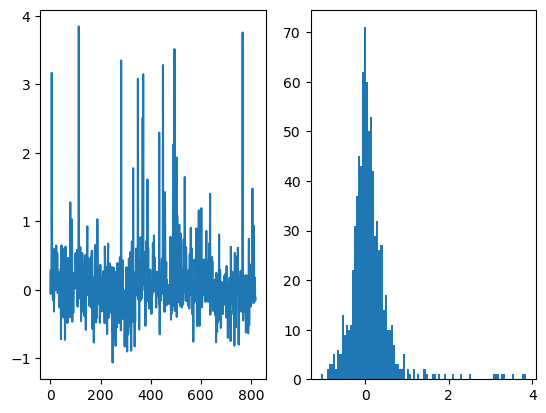

In [7]:
fig,axx=plt.subplots(1,2)
axx[0].plot(np.asarray(res_list)[:,2])
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

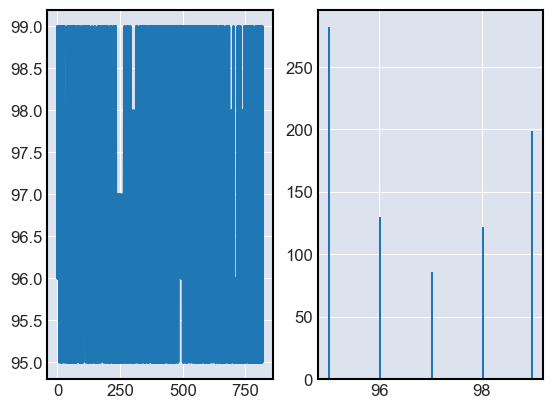

In [153]:
fig,axx=plt.subplots(1,2)
axx[0].plot(np.asarray(res_list)[:,1])
axx[1].hist(np.asarray(res_list)[:,1],bins=100);

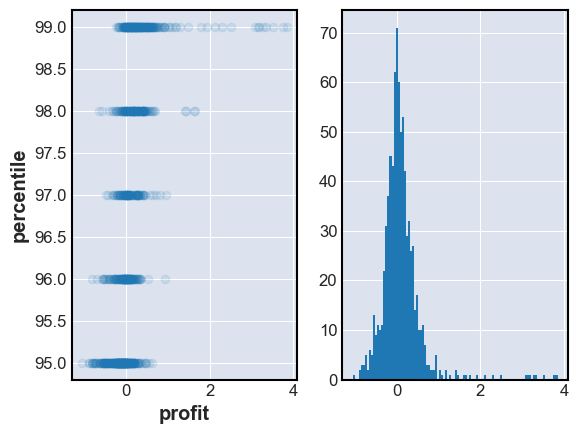

In [158]:
fig,axx=plt.subplots(1,2)
axx[0].scatter(np.asarray(res_list)[:,2],np.asarray(res_list)[:,1],alpha=0.1)
axx[0].set_xlabel("profit")
axx[0].set_ylabel("percentile")
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

In [164]:
np.where(np.asarray(res_list)[:,2]>0.4)

(array([  5,   6,  16,  17,  23,  27,  43,  44,  45,  56,  60,  64,  70,
         73,  79,  81,  86, 100, 106, 111, 113, 119, 127, 140, 146, 147,
        152, 153, 159, 163, 165, 177, 178, 179, 181, 187, 217, 230, 277,
        282, 288, 313, 317, 319, 325, 330, 342, 349, 353, 360, 366, 368,
        370, 374, 377, 382, 387, 390, 409, 413, 416, 434, 445, 449, 457,
        458, 462, 479, 486, 487, 491, 493, 495, 498, 503, 506, 514, 518,
        520, 531, 532, 534, 536, 541, 542, 556, 560, 563, 575, 582, 583,
        592, 600, 602, 612, 619, 622, 628, 633, 635, 637, 644, 646, 673,
        720, 736, 746, 748, 767, 792, 806, 809, 812], dtype=int64),)

In [8]:
[tradingpairs[ind]["symbol"] for ind in np.where(np.asarray(res_list)[:,2]>0.4)[0]]

['XRPUSDT',
 'SOLUSDT',
 'DOGEUSDT',
 'MATICUSDT',
 'LINAUSDT',
 'ADAUSDT',
 'CAKEUSDT',
 'USTCUSDT',
 'EGLDUSDT',
 'SANDUSDT',
 'BELUSDT',
 'ROSEUSDT',
 'EOSUSDT',
 'NEARUSDT',
 'BCHUSDT',
 'REEFUSDT',
 'SNXUSDT',
 'FXSUSDT',
 'CRVUSDT',
 'BANDUSDT',
 'XLMUSDT',
 'SUSHIUSDT',
 'KLAYUSDT',
 'MKRUSDT',
 'CKBUSDT',
 'XECUSDT',
 'FLOWUSDT',
 'WAVESUSDT',
 'HOTUSDT',
 'COTIUSDT',
 'IOTAUSDT',
 'LITUSDT',
 'QUICKUSDT',
 'BETHUSDT',
 'CHRUSDT',
 'QTUMUSDT',
 'GLMRUSDT',
 'BSWUSDT',
 'MTLUSDT',
 'FLMUSDT',
 'STORJUSDT',
 'PNTUSDT',
 'XVGUSDT',
 'PROSUSDT',
 'FUNUSDT',
 'FORTHUSDT',
 'BNBETH',
 'XRPBNB',
 'IDEXBNB',
 'AVAXBNB',
 'SOLETH',
 'XRPETH',
 'XRPBTC',
 'BNBBTC',
 'FILBNB',
 'LTCETH',
 'BCHBNB',
 'ADAETH',
 'AVAXETH',
 'STXBNB',
 'DYDXBNB',
 'BSWBNB',
 'VETETH',
 'XLMBNB',
 'FUNBNB',
 'CFXBTC',
 'BETAETH',
 'LINABTC',
 'IDEXBTC',
 'FILETH',
 'JASMYBTC',
 'AVAXBTC',
 'XLMETH',
 'FTMETH',
 'XLMBTC',
 'BCHBTC',
 'STMXBTC',
 'ETCBTC',
 'QNTBTC',
 'OPBTC',
 'MAGICBTC',
 'SNXBNB',
 'FUNETH',

In [165]:
res_list[5]

(0.38898530791702507, 99, 3.1699728311641477)

In [170]:
%%time
ind=5;percentile=99
tickerpair = tradingpairs[ind]["symbol"]
limit=1000
dfmpl = get_data(tickerpair,"1h",limit=limit)
#print(len(dfmpl))
dfmpl=dfmpl.iloc[-limit:]
x=dfmpl.Volume.iloc[:-1].values
y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
#selected= (y!=0) & (x!=0)
#res = stats.linregress(np.log(x[selected]),np.log( y[selected]))
selected_per=x>np.percentile(x,percentile)
diff_list=[ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1]
diff = np.mean(diff_list)

CPU times: total: 62.5 ms
Wall time: 208 ms


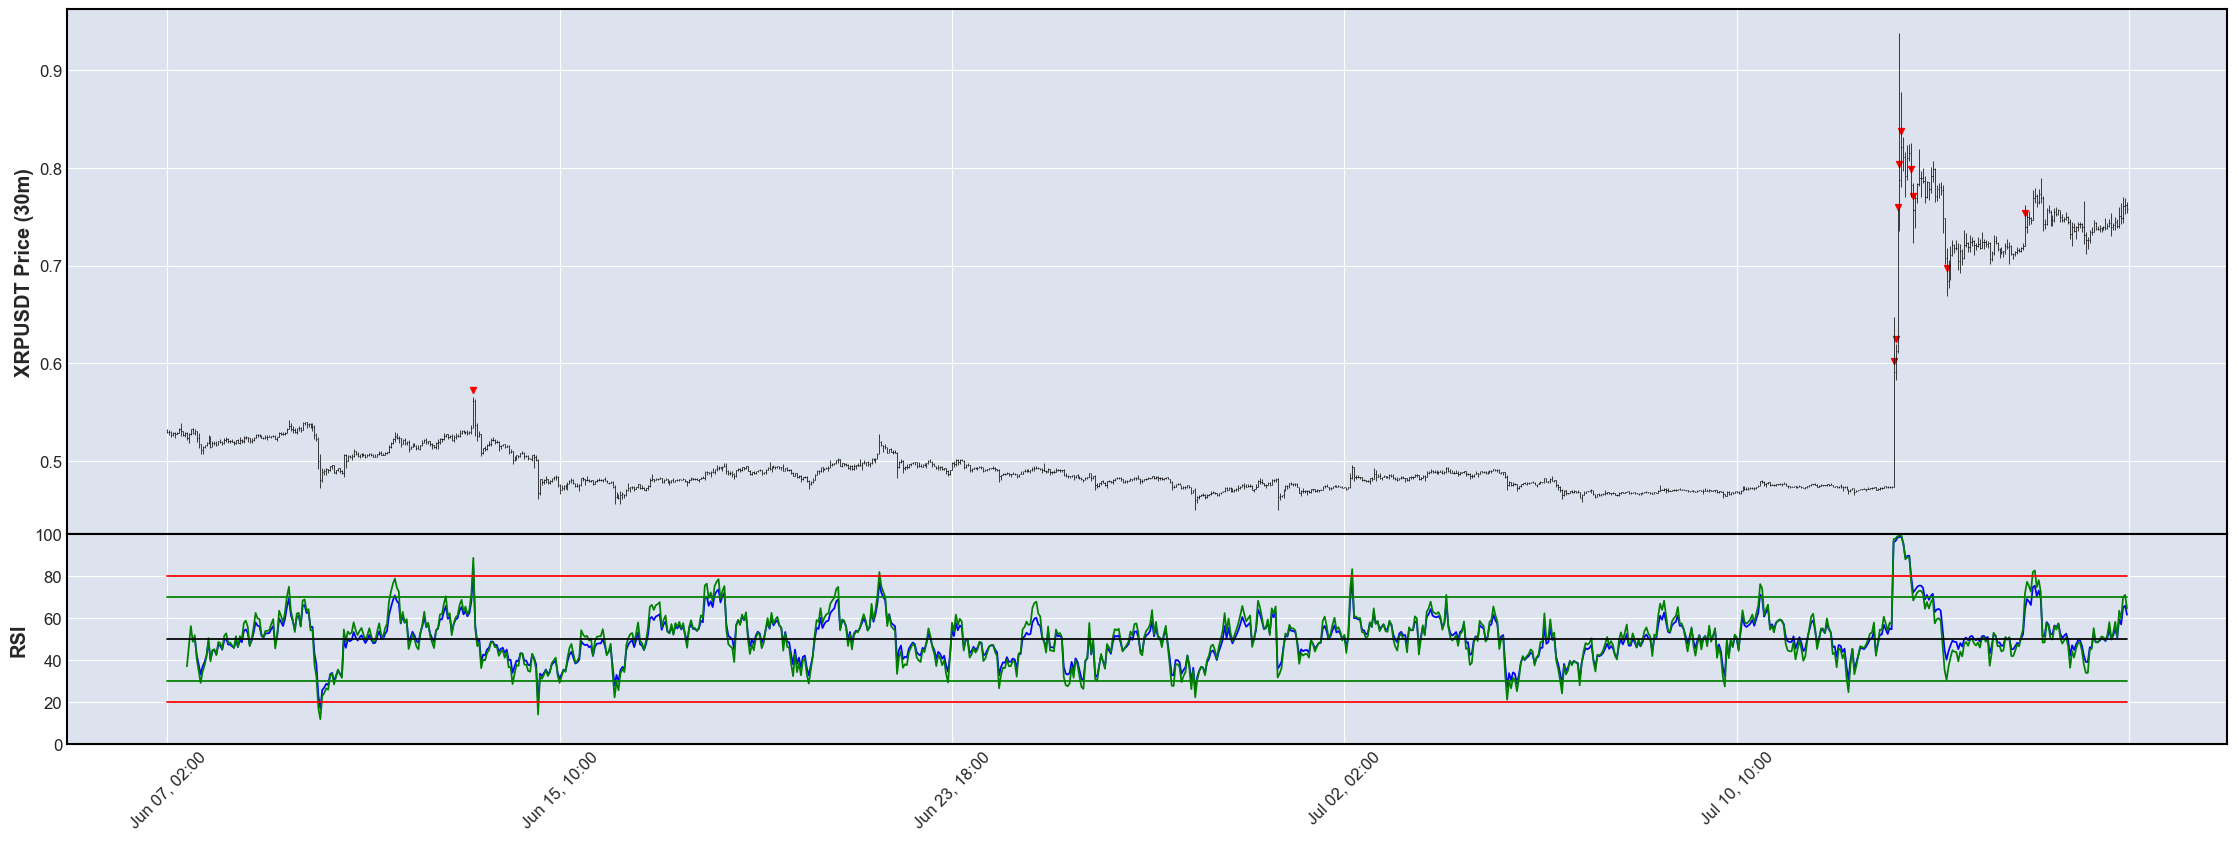

In [173]:
volumeSpike = np.where(selected_per)[0]
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]
len(volumeSpike)
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)

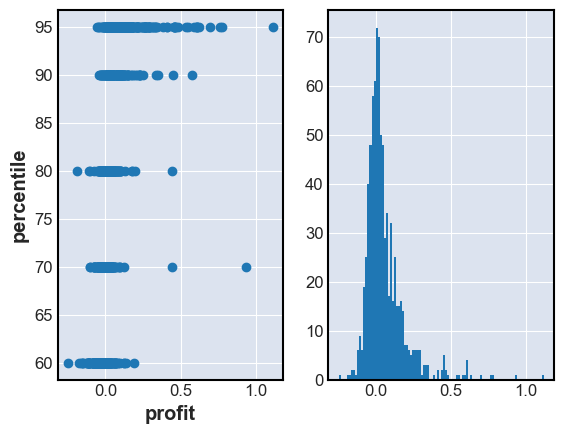

In [148]:
fig,axx=plt.subplots(1,2)
axx[0].scatter(np.asarray(res_list)[:,2],np.asarray(res_list)[:,1])
axx[0].set_xlabel("profit")
axx[0].set_ylabel("percentile")
axx[1].hist(np.asarray(res_list)[:,2],bins=100);

In [69]:
np.where(np.asarray(res_list)>0.5)

(array([ 79, 147, 174, 303, 317], dtype=int64),)

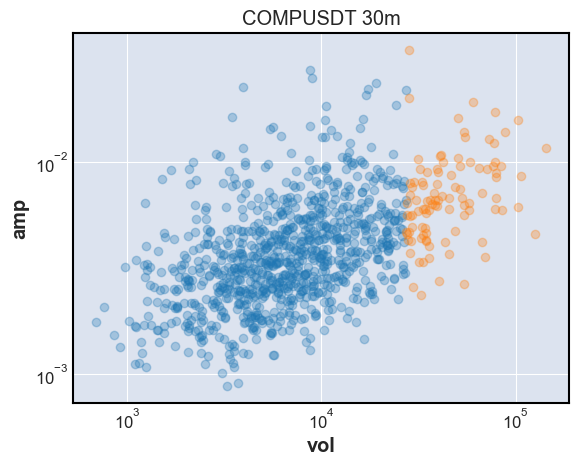

In [130]:
ind=174
tickerpair = tradingpairs[ind]["symbol"]
limit=1000
interval="30m"
dfmpl = get_data(tickerpair,interval,limit=limit)
#print(len(dfmpl))
dfmpl=dfmpl.iloc[-limit:]
x=dfmpl.Volume.iloc[:-1].values
y=((dfmpl.High-dfmpl.Low)*0.5/(dfmpl.High+dfmpl.Low)).iloc[1:].values
selected= (y!=0) & (x!=0)
    
selected_per=x>np.percentile(x,90)
plt.scatter(x[~selected_per],y[~selected_per],alpha=0.3)
plt.scatter(x[selected_per],y[selected_per],alpha=0.3)
plt.title(tickerpair+f" {interval}")
plt.xlabel("vol")
plt.ylabel("amp")
plt.yscale("log")
plt.xscale("log")

Text(0.5, 1.0, 'avg diff=0.13%, trades=100')

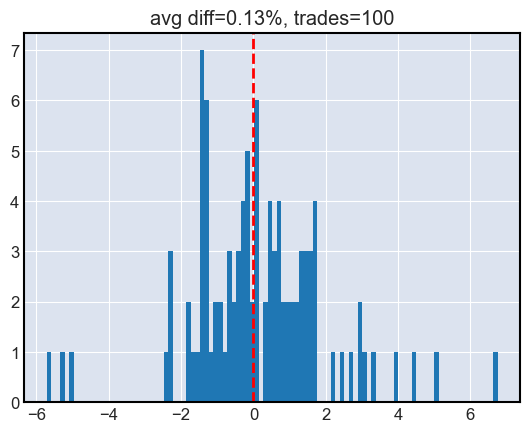

In [133]:
diff = [ (dfmpl.Close.iloc[i]-dfmpl.Open.iloc[i])/dfmpl.Open.iloc[i]*100 for i in np.where(selected_per)[0]+1]
plt.hist(diff,bins=100);
plt.axvline(0,ls="--",c="r")
plt.title(f"avg diff={np.mean(diff):.2g}%, trades={len(diff)}")

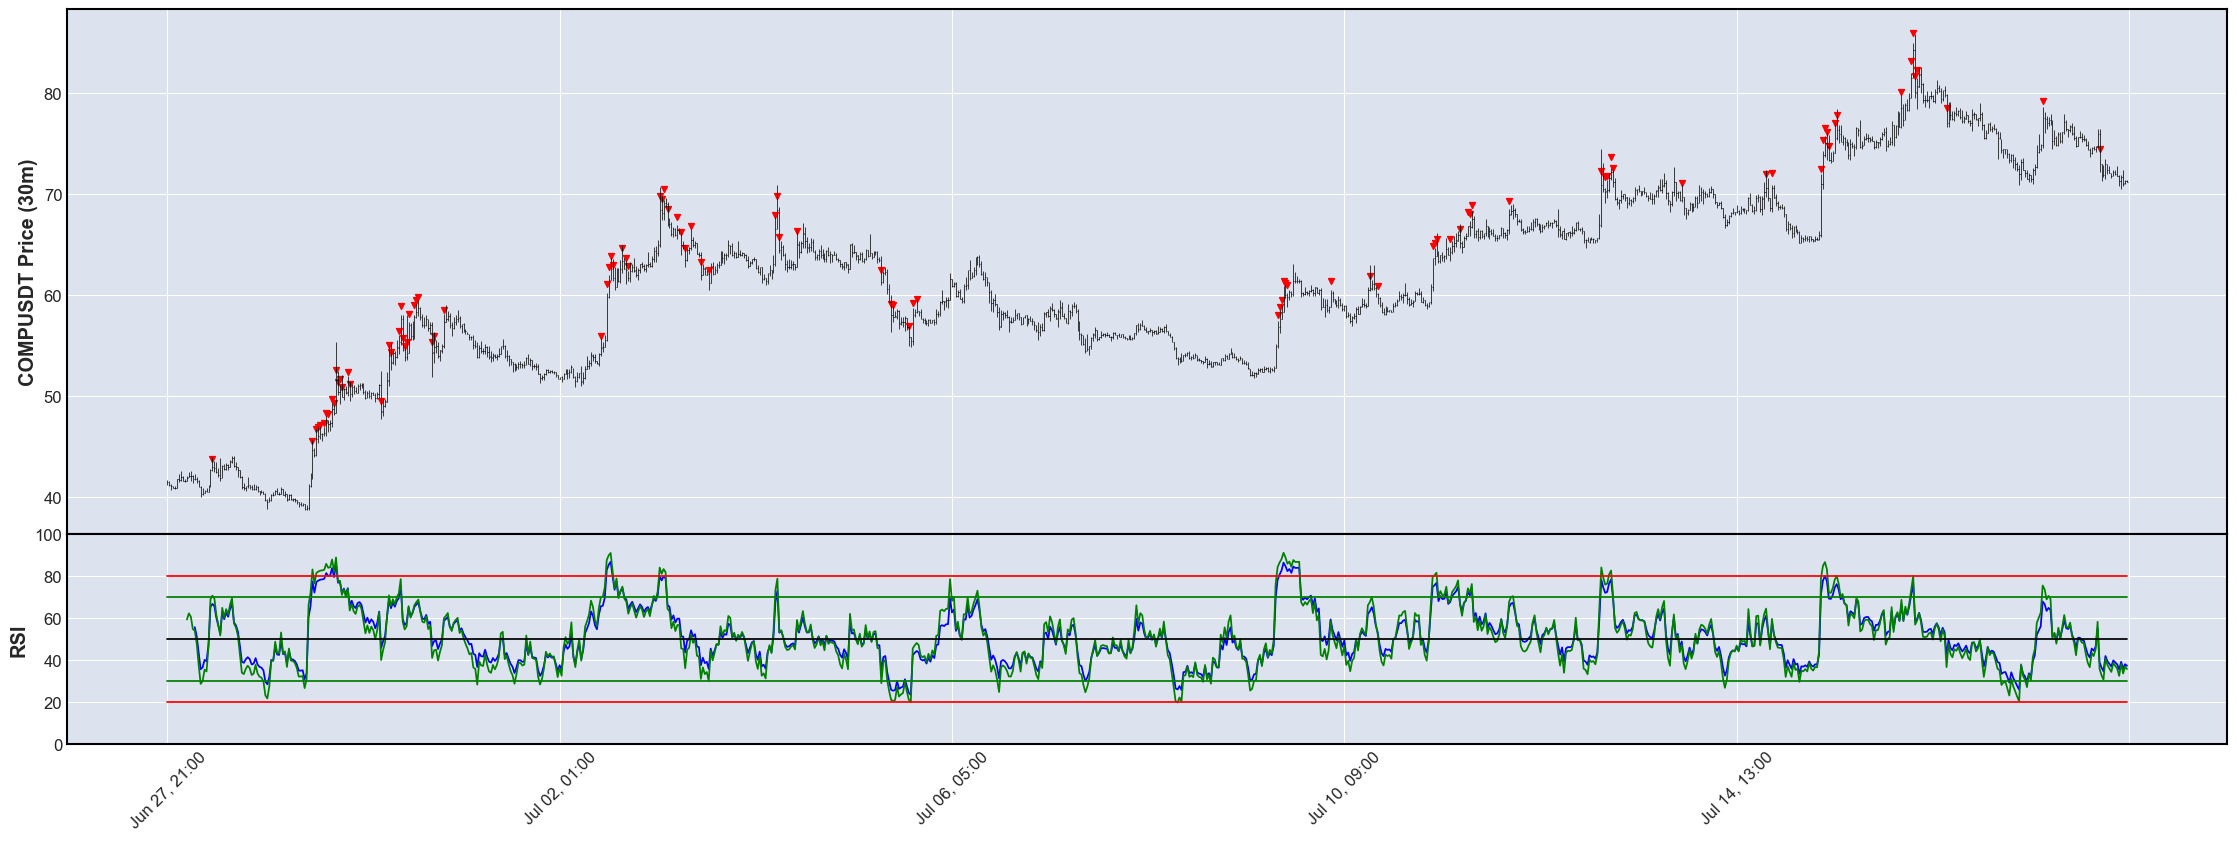

In [132]:
volumeSpike = np.where(selected_per)[0]
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]
len(volumeSpike)
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)

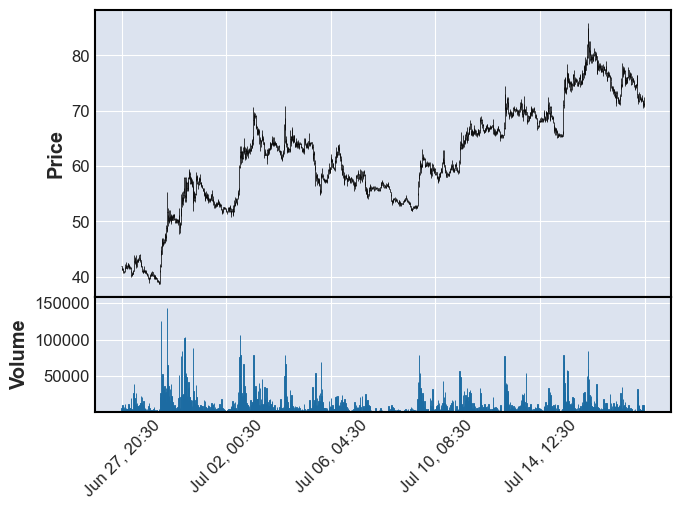

In [96]:
mpf.plot(dfmpl,type="ohlc",warn_too_much_data=2000,volume=True)

In [97]:
ws=10
#volumeSpike = np.where(dfmpl.Volume>(dfmpl.Volume.rolling(ws).mean()+dfmpl.Volume.rolling(ws).std()*2))[0]
volumeSpike = np.where(dfmpl.Volume>(dfmpl.Volume.rolling(ws).mean())*5)[0]
len(volumeSpike)

7

In [98]:
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in volumeSpike else np.nan for i in np.arange(len(dfmpl.Close))]

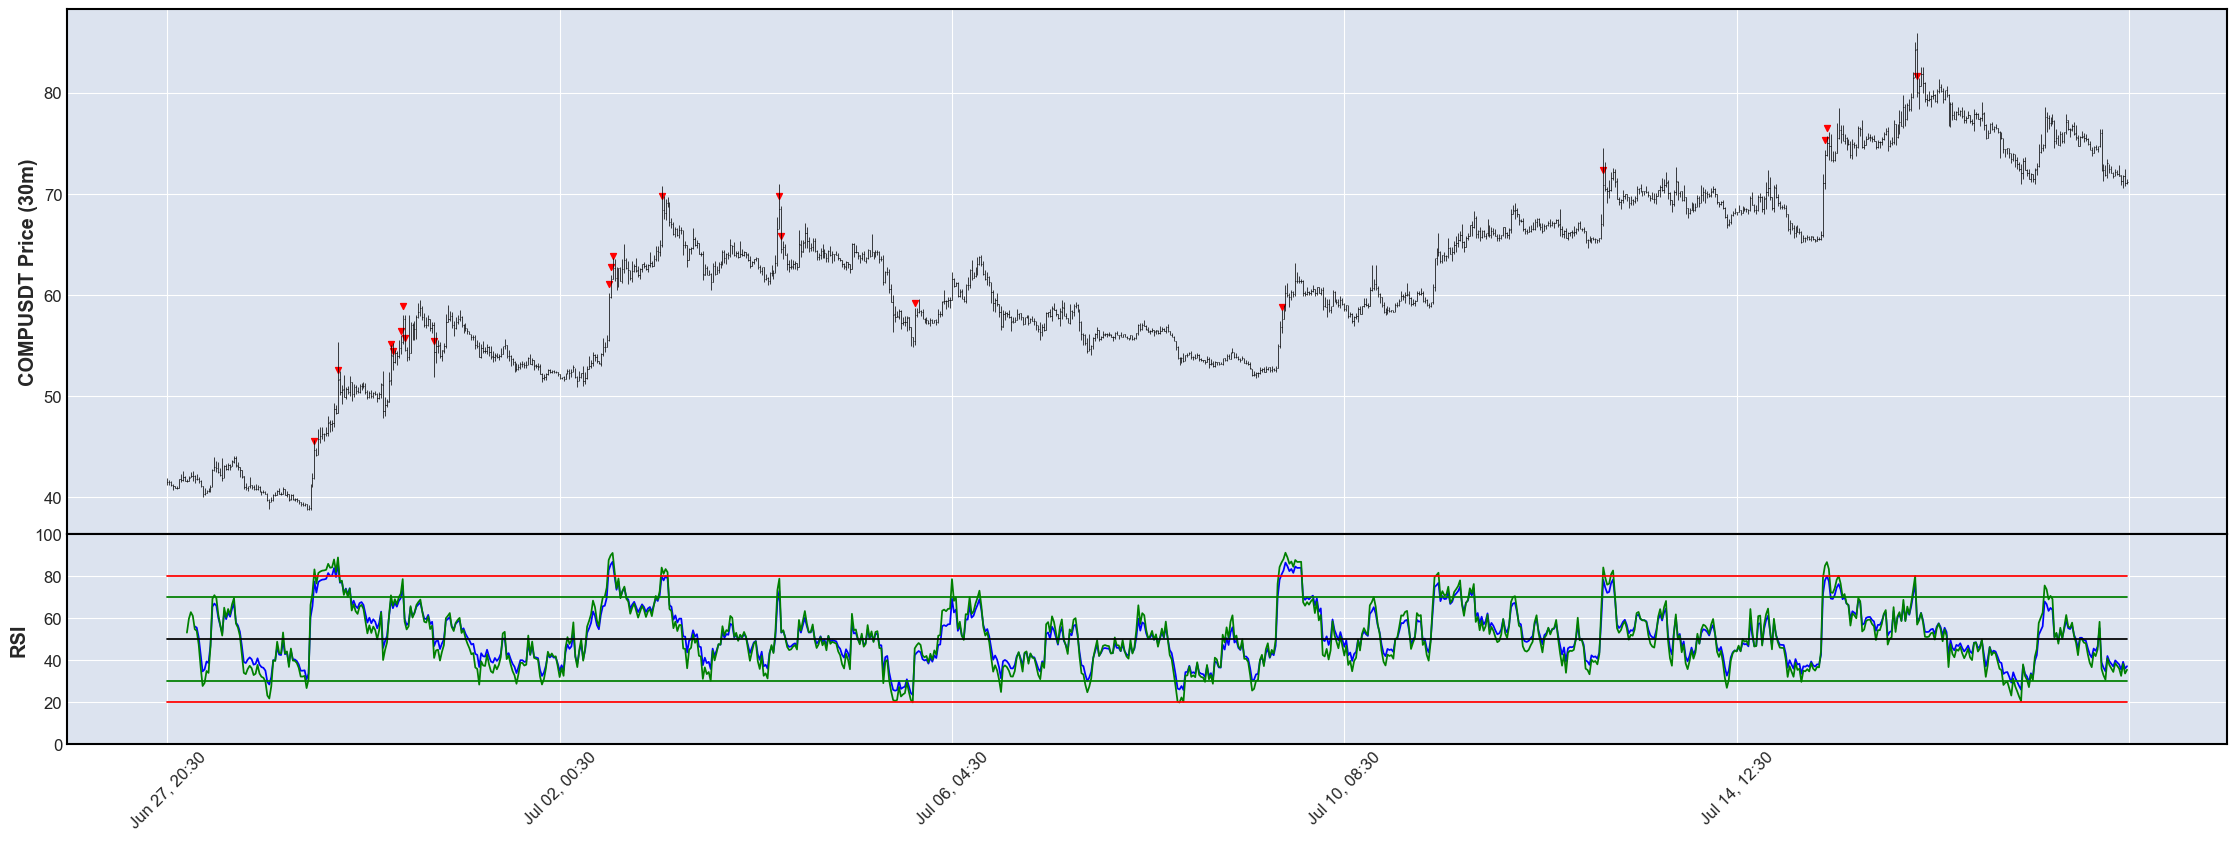

In [100]:
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]

fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)